In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from numpy.lib.stride_tricks import as_strided as strided
import cv2
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from scipy.spatial import distance
import time

In [2]:
coordinates = pd.read_csv('3d_coordinates.csv')
coordinates = coordinates.rename(columns={'Unnamed: 0':'frames'}).drop(['frames'], axis=1)

In [7]:
""" KALMAN FILTER """

measurement = np.zeros((3,1),dtype=np.float32)
state = np.zeros((9,1),dtype=np.float32)
kalman = cv2.KalmanFilter(9,3,0)

def initKalman(x,y,z):
    measurement[0][0] = x
    measurement[1][0] = y
    measurement[2][0] = y
    kalman.statePre = np.zeros((9,1),dtype=np.float32)
    kalman.statePre[0,0] = x
    kalman.statePre[1,0] = y
    kalman.statePre[2,0] = z
    kalman.statePost = np.zeros((9,1),dtype=np.float32)
    kalman.statePost[0,0] = x
    kalman.statePost[1,0] = y
    kalman.statePost[2,0] = z
    kalman.measurementMatrix=cv2.setIdentity(kalman.measurementMatrix)
    kalman.processNoiseCov=cv2.setIdentity(kalman.processNoiseCov, .01)
    kalman.measurementNoiseCov=cv2.setIdentity(kalman.measurementNoiseCov, .1)
    kalman.errorCovPost=cv2.setIdentity(kalman.errorCovPost, .1)
    dt=1/200
    v = dt
    a = 0.5*(dt**2)
    
    kalman.transitionMatrix = np.array([
                                [1, 0, 0, v, 0, 0, a, 0, 0],
                                [0, 1, 0, 0, v, 0, 0, a, 0],
                                [0, 0, 1, 0, 0, v, 0, 0, a],
                                [0, 0, 0, 1, 0, 0, v, 0, 0],
                                [0, 0, 0, 0, 1, 0, 0, v, 0],
                                [0, 0, 0, 0, 0, 1, 0, 0, v],
                                [0, 0, 0, 0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0, 1]], np.float32)

def kalmanPredict():
    prediction = kalman.predict()
    predictPr = [prediction[0,0],prediction[1,0],prediction[2,0]]
    return predictPr

def kalmanCorrect(x,y,z):
    measurement[0,0] = x
    measurement[1,0] = y
    measurement[2,0] = z
    estimated = kalman.correct(measurement)
    return [estimated[0,0],estimated[1,0],estimated[2,0]]

def mask_knans(a, x):
    a = np.asarray(a)
    k = a.size
    n = np.append(np.isnan(a), [False] * (x - 1))
    m = np.empty(k, np.bool8)
    m.fill(True)

    s = n.strides[0]
    i = np.where(strided(n, (k + 1 - x, x), (s, s)).all(1))[0][:, None]
    i = i + np.arange(x)
    i = pd.unique(i[i < k])

    m[i] = False

    return m

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(~mask_knans(A,3),A,f(inds))
    return B

initialized=False
#sorted_coordinates = coordinates.sort_values(by=['bodypart', 'frame'])
bodyparts=pd.unique(coordinates['bodypart'])
filtered_coordinates=[]
# browse the bodyparts
for bodypart in bodyparts:
    corrected=[]
    #filter coordinates by bodypart
    single_bp = coordinates[coordinates['bodypart'] == bodypart].loc[:,['x','y','z']]
    single_bp = np.array(single_bp)
    for idx in range(len(single_bp)):
        coordinate=single_bp[idx]
        if not np.any(np.isnan(coordinate)):
            if not initialized:
                initKalman(coordinate[0],coordinate[1],coordinate[2])
                initialized=True
                corrected.append(coordinate)
            else:
                p = kalmanPredict()
                s = kalmanCorrect(coordinate[0],coordinate[1],coordinate[2]);   
                corrected.append(s)
        else:
            corrected.append(coordinate)
    corrected=np.vstack(corrected)

    for i in range(3):
        corrected[:,i]=fill_nan(corrected[:,i])
        
    filtered_coordinates.append(corrected)

In [9]:
kal = coordinates.sort_values(by=['bodypart', 'frame'])
kal

,frame,x,y,z,bodypart
0,0.0,NaN,NaN,NaN,elbow
21,1.0,NaN,NaN,NaN,elbow
42,2.0,NaN,NaN,NaN,elbow
63,3.0,NaN,NaN,NaN,elbow
84,4.0,NaN,NaN,NaN,elbow
...,...,...,...,...,...
10669,508.0,0.081528,-0.344655,-0.032526,wrist
10690,509.0,0.081479,-0.344670,-0.032602,wrist
10711,510.0,0.081453,-0.344681,-0.032621,wrist
10732,511.0,0.081453,-0.344731,-0.032617,wrist


In [114]:
kalman_coordinates = pd.DataFrame.from_records(data=np.vstack(filtered_coordinates), columns=['x', 'y', 'z'])
kalman_coordinates['bodypart'] = kal['bodypart']
kalman_coordinates['frame'] = coordinates['frame'].reset_index(drop=True)
kalman_coordinates

NameError: name 'filtered_coordinates' is not defined

In [283]:
# plt.figure(figsize=(16, 8))
# z = sns.lineplot(data=kalman_coordinates, x=kalman_coordinates['frame'], y=kalman_coordinates['y'], hue=kalman_coordinates['bodypart'])

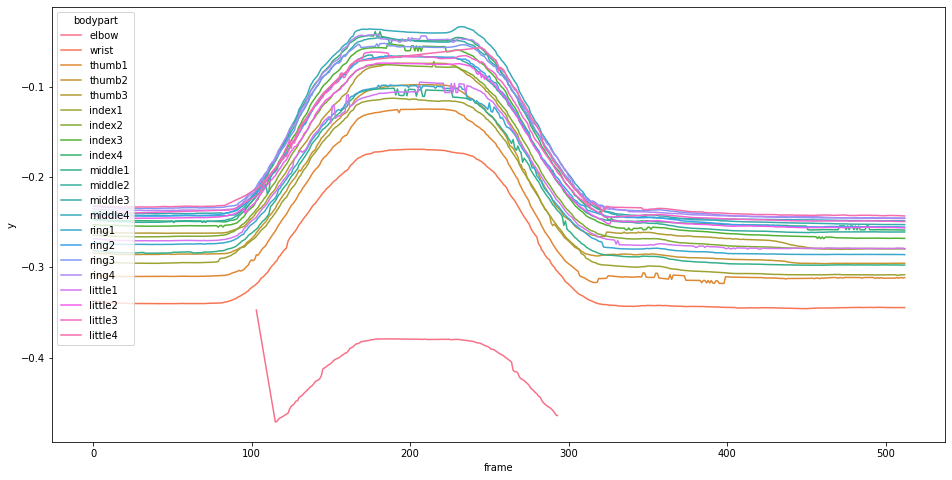

In [16]:
plt.figure(figsize=(16, 8))
z = sns.lineplot(data=coordinates, x=coordinates['frame'], y=coordinates['y'], hue=coordinates['bodypart'])

In [8]:
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import as_strided as strided

def low_pass_filter(coord):

    #Filter requirements
    T = len(coord)/200 # video time
    fps = 200 # frame per rate
    cutoff = 8 # desired cutoff frequency of the filter
    nyq = 0.5 * fps # Nyquist Frequency
    order = 2 # sin wave can be approx represented as quadratic
    normal_cutoff = cutoff / nyq

    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y=np.zeros(coord.shape)*float('NaN')
    y[~np.isnan(coord)] = filtfilt(b, a, coord[~np.isnan(coord)])
    return y

In [9]:
""" Low-pass filter """
bodypart = coordinates[coordinates['bodypart'] == 'wrist']
bodypart_coord = bodypart['x']
y = low_pass_filter(bodypart_coord)
low_pass_bodypart = pd.DataFrame(y, columns = ['x'])
low_pass_bodypart['frame'] = low_pass_bodypart.index
print(low_pass_bodypart)

            x  frame
0    0.081454      0
1    0.081414      1
2    0.081378      2
3    0.081346      3
4    0.081321      4
..        ...    ...
508  0.081453    508
509  0.081461    509
510  0.081471    510
511  0.081482    511
512  0.081493    512

[513 rows x 2 columns]


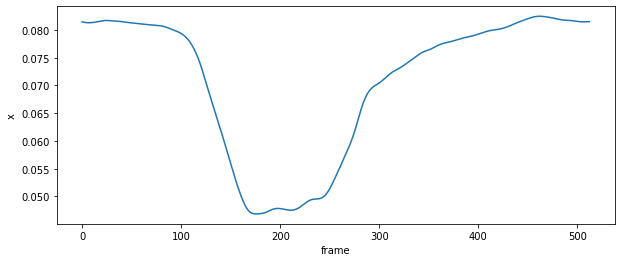

In [11]:
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=low_pass_bodypart, x=low_pass_bodypart['frame'], y=low_pass_bodypart['x'])

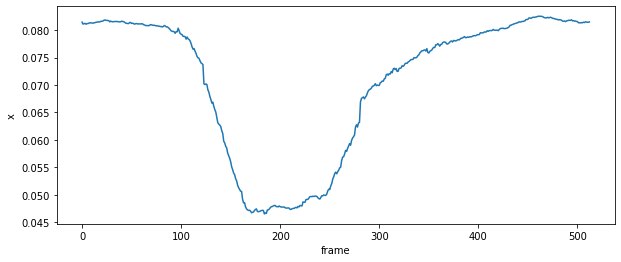

In [12]:
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=bodypart, x=bodypart['frame'], y=bodypart['x'])

In [113]:
bodypart = coordinates[coordinates['bodypart'] == 'thumb1']
bodypart_x = np.array(bodypart['x'])
coord = low_pass_filter(bodypart_x)
low_pass_elbow = pd.DataFrame(coord, columns = ['x'])
low_pass_elbow['frame'] = low_pass_elbow.index
# low_pass_elbow

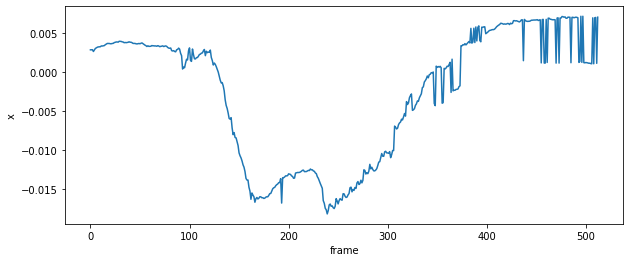

In [15]:
# thumb1 - x - without low pass filter
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=bodypart, x=bodypart['frame'], y=bodypart['x'])

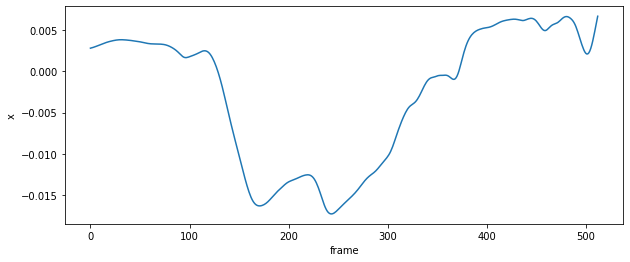

In [17]:
# thumb1 - x - with low pass filter
plt.figure(figsize=(10, 4))
z = sns.lineplot(data=low_pass_elbow, x=low_pass_elbow['frame'], y=low_pass_elbow['x'])

In [4]:
lpf_coord = pd.read_csv('saved_pairs/low_pass_filter/coordinates.csv')
kalman_coord = pd.read_csv('saved_pairs/kalman_filter/coordinates.csv')
nofil_coord = pd.read_csv('saved_pairs/no_filter/coordinates.csv')

In [5]:
# Build the skeleton
skeleton = [['elbow', 'wrist'], ['wrist', 'thumb1'], ['thumb1', 'thumb2'], ['thumb2', 'thumb3'], [
    'wrist', 'index1'], ['index1', 'index2'], ['index2', 'index3'], ['index3', 'index4'], ['wrist',
    'middle1'], ['middle1', 'middle2'], ['middle2', 'middle3'], ['middle3', 'middle4'], ['wrist',
    'ring1'], ['ring1', 'ring2'], ['ring2', 'ring3'], ['ring3', 'ring4'], ['wrist', 'little1'], ['little1',
    'little2'], ['little2', 'little3'], ['little3', 'little4']]

eucl_dst_lpf = {}
eucl_dst_kf = {}
eucl_dst_nofil = {}
for bp1, bp2 in skeleton:
    joint='{}_{}'.format(bp1,bp2)
    eucl_dst_lpf[joint]=[]
    eucl_dst_kf[joint]=[]
    eucl_dst_nofil[joint]=[]
    
# Compute the euclidean distance between joints for each frame
for frame in lpf_coord['frame'].unique():
    frames = lpf_coord[lpf_coord['frame'] == frame]
    for bp1, bp2 in skeleton:
        joint='{}_{}'.format(bp1,bp2)
        data1 = frames[frames['bodypart'] == bp1]
        data2 = frames[frames['bodypart'] == bp2]
        data1_xyz = np.array([data1['x'], data1['y'], data1['z']])
        coord1 = np.hstack(data1_xyz)
        data2_xyz = np.array([data2['x'], data2['y'], data2['z']])
        coord2 = np.hstack(data2_xyz)
        if ~np.isnan(coord1).any() and ~np.isnan(coord2).any():
            eucl_dst_lpf[joint].append(distance.euclidean(coord1, coord2))
        else:
            eucl_dst_lpf[joint].append(np.float64('nan'))
            
for frame in kalman_coord['frame'].unique():
    frames = kalman_coord[kalman_coord['frame'] == frame]
    for bp1, bp2 in skeleton:
        joint='{}_{}'.format(bp1,bp2)
        data1 = frames[frames['bodypart'] == bp1]
        data2 = frames[frames['bodypart'] == bp2]
        data1_xyz = np.array([data1['x'], data1['y'], data1['z']])
        coord1 = np.hstack(data1_xyz)
        data2_xyz = np.array([data2['x'], data2['y'], data2['z']])
        coord2 = np.hstack(data2_xyz)
        if ~np.isnan(coord1).any() and ~np.isnan(coord2).any():
            eucl_dst_kf[joint].append(distance.euclidean(coord1, coord2))
        else:
            eucl_dst_kf[joint].append(np.float64('nan'))

for frame in nofil_coord['frame'].unique():
    frames = nofil_coord[nofil_coord['frame'] == frame]
    for bp1, bp2 in skeleton:
        joint='{}_{}'.format(bp1,bp2)
        data1 = frames[frames['bodypart'] == bp1]
        data2 = frames[frames['bodypart'] == bp2]
        data1_xyz = np.array([data1['x'], data1['y'], data1['z']])
        coord1 = np.hstack(data1_xyz)
        data2_xyz = np.array([data2['x'], data2['y'], data2['z']])
        coord2 = np.hstack(data2_xyz)
        if ~np.isnan(coord1).any() and ~np.isnan(coord2).any():
            eucl_dst_nofil[joint].append(distance.euclidean(coord1, coord2))
        else:
            eucl_dst_nofil[joint].append(np.float64('nan'))

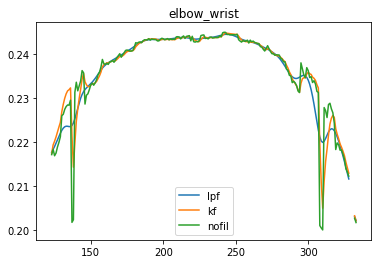

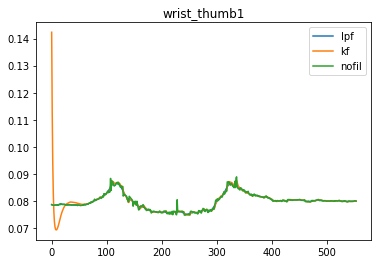

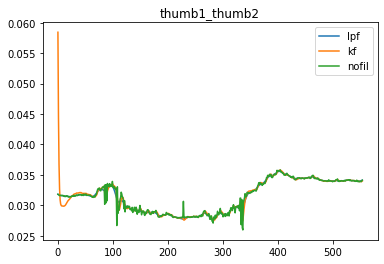

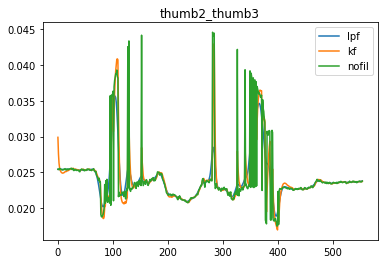

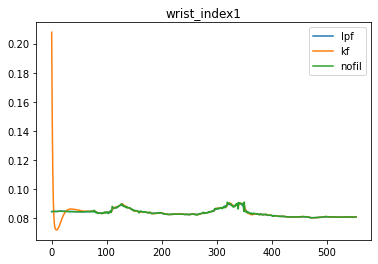

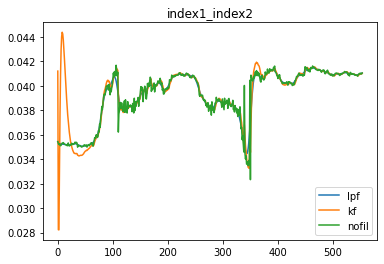

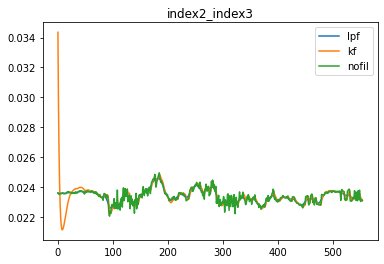

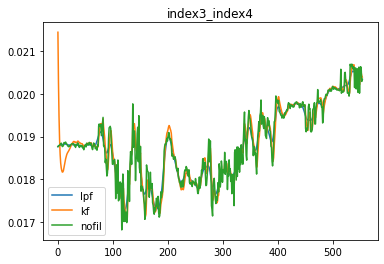

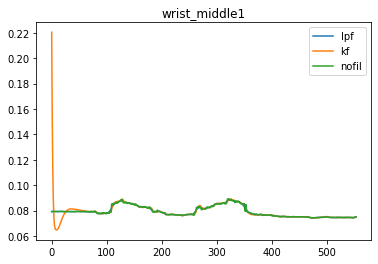

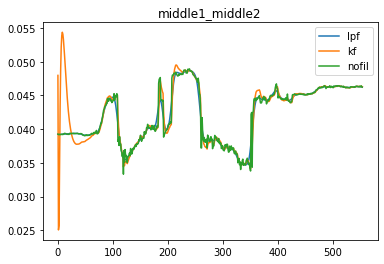

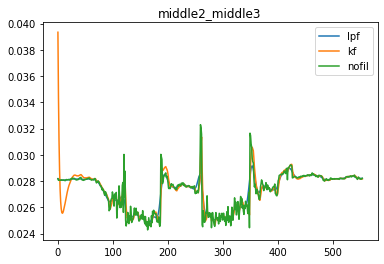

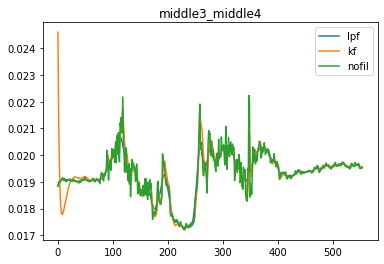

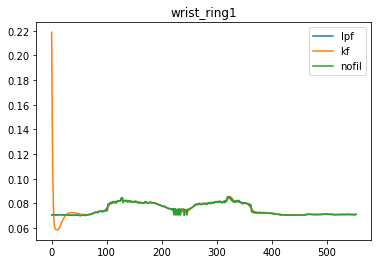

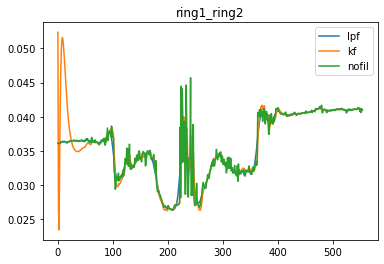

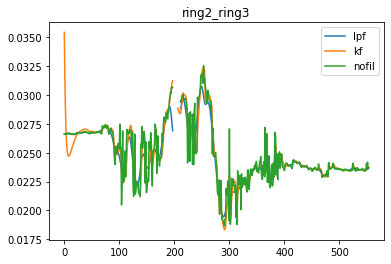

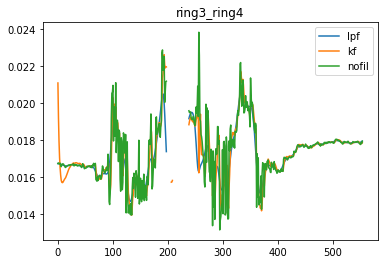

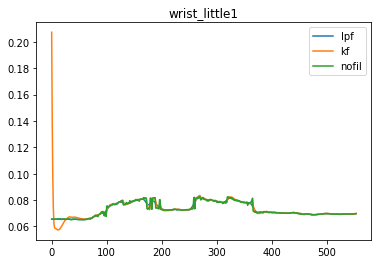

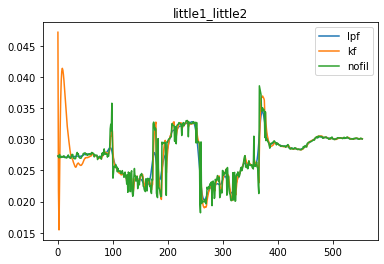

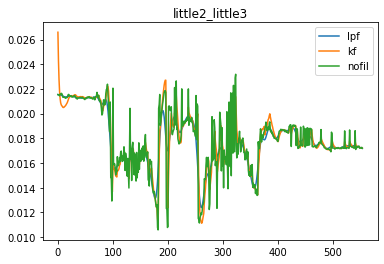

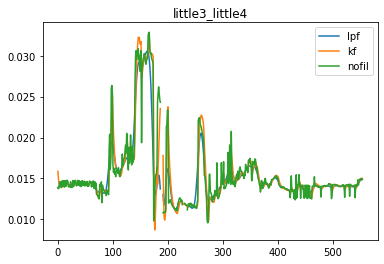

NameError: name 'length_joints' is not defined

In [20]:
pairs = list(eucl_dst_kf.keys())
length_joints_lpf = list(eucl_dst_lpf.values())
length_joints_kf = list(eucl_dst_kf.values())
length_joints_nofil = list(eucl_dst_nofil.values())
frames = [i for i in range(0, len(length_joints_lpf[0]))]

for i in range(0, len(pairs)):
    plt.plot(frames, length_joints_lpf[i], label='lpf')
    plt.plot(frames, length_joints_kf[i], label='kf')
    plt.plot(frames, length_joints_nofil[i], label='nofil')
    plt.title(pairs[i])
    plt.legend()
    plt.show()

In [6]:
# Fix the joints length under the constraints of the median
# Picking first frames from the length joints except for the elbow-wrist (200->250)
length_joints_lpf = list(eucl_dst_lpf.values())

# Take the plateau of the elbow - wrist length
elb_wri_dst = length_joints_lpf[0][200:250]
length_joints = [elb_wri_dst]

# Take first frames of each plot (plateau)
for joint in range(1, len(length_joints_lpf)):
    bodypart_first_dst = length_joints_lpf[joint][0:50]
    length_joints.append(bodypart_first_dst)

# Computing median
median_joints = []
for length_table in length_joints:
    median_joints.append(np.nanmedian(length_table))

In [10]:
# BFGS method
def cost(params):
    split_coords = np.array_split(params, 2)
    new_wrist = np.array_split(split_coords[0], 554)
    new_thumb = np.array_split(split_coords[1], 554)
    new_length = np.zeros((orig_wrist.shape[0],1))

    for i in range(orig_wrist.shape[0]):
        new_length[i]=distance.euclidean(new_wrist[i], new_thumb[i])
    length_cost=np.sum(abs(new_length-orig_skel_length))
    
    new_dist = np.zeros((orig_wrist.shape[0],1))
    for i in range(orig_wrist.shape[0]):
        new_dist[i]=distance.euclidean(new_wrist[i], np.array(orig_wrist.iloc[i]))+distance.euclidean(new_thumb[i], np.array(orig_thumb.iloc[i]))
    dist_cost=np.sum(new_dist)

    c = (alpha * length_cost) + ((1-alpha) * dist_cost)
    
    return c

# Get data
orig_wrist = lpf_coord[lpf_coord['bodypart'] == 'wrist'][['x', 'y', 'z']]
orig_wrist.index=range(len(orig_wrist))
orig_thumb = lpf_coord[lpf_coord['bodypart'] == 'middle1'][['x', 'y', 'z']]
orig_thumb.index=range(len(orig_thumb))
orig_skel_length = median_joints[1]

# Init params
alpha = 1

# Compute the optimisation and add new 3d coordinates to tables
x0=[orig_wrist,orig_thumb]

start = time.time()
method   ="BFGS"
tol      = 0.01
options  = {"maxiter":50, "disp":True}
new_coords=minimize(cost, x0, method=method, tol=tol, options=options)
print(new_coords)
end = time.time()
new_coords = np.array_split(new_coords.x, 2)

print(f"Runtime of the program is {end - start}")

         Current function value: 0.096251
         Iterations: 50
         Function evaluations: 242725
         Gradient evaluations: 73
      fun: 0.09625119325337463
 hess_inv: array([[ 0.98634431,  0.01868259,  0.01519712, ..., -0.00190304,
         0.00307913,  0.00343968],
       [ 0.01868259,  0.97444002, -0.02079145, ...,  0.00260355,
        -0.00421256, -0.00470584],
       [ 0.01519712, -0.02079145,  0.98308746, ...,  0.00211784,
        -0.00342667, -0.00382793],
       ...,
       [-0.00190304,  0.00260355,  0.00211784, ...,  0.98951974,
         0.01695762,  0.01894278],
       [ 0.00307913, -0.00421256, -0.00342667, ...,  0.01695762,
         0.97256166, -0.03065042],
       [ 0.00343968, -0.00470584, -0.00382793, ...,  0.01894278,
        -0.03065042,  0.96576146]])
      jac: array([-0.49325176,  0.67482025,  0.54892647, ..., -0.38110656,
        0.61665081,  0.68883935])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 242725
      nit: 50
     

In [11]:
# prepare the data for display
new_wrist = []
new_thumb = []

new_wrist.append(new_coords[0])
new_thumb.append(new_coords[1])

new_wrist = np.array_split(new_wrist[0], 554)
new_wrist_coords = np.vstack(new_wrist)

new_thumb = np.array_split(new_thumb[0], 554)
new_thumb_coords = np.vstack(new_thumb)

Text(0.5, 1.0, 'thumb')

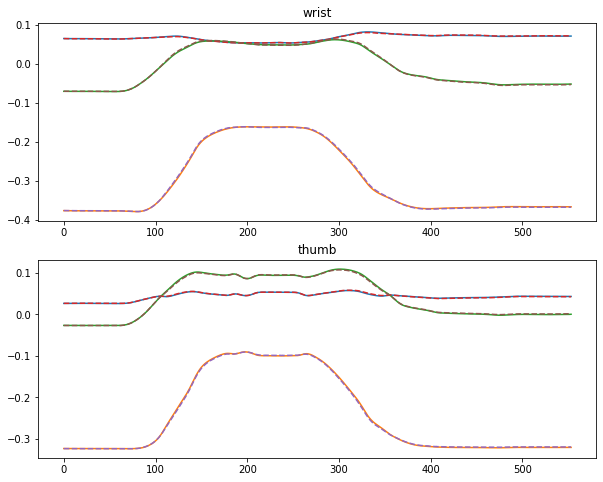

In [12]:
# Low Pass Filter coordinates - Optimisation coordinates plots
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(orig_wrist)
plt.plot(new_wrist_coords,'--')
plt.title("wrist")
plt.subplot(212)
plt.plot(orig_thumb)
plt.plot(new_thumb_coords,'--')
plt.title("thumb")

In [147]:
np.sum(new_wrist_coords[:,0]-orig_wrist.iloc[:,0])

-0.6902573064736683

In [13]:
# wrist and thumb 3d coordinates dataframe after optimisation
wrist_coord = pd.DataFrame(new_wrist_coords, columns = ['x', 'y', 'z'])
wrist_coord['frame'] = wrist_coord.index
thumb1_coord = pd.DataFrame(new_thumb_coords, columns = ['x', 'y', 'z'])
thumb1_coord['frame'] = thumb1_coord.index

Text(0.5, 1.0, 'x wrist before/after optim')

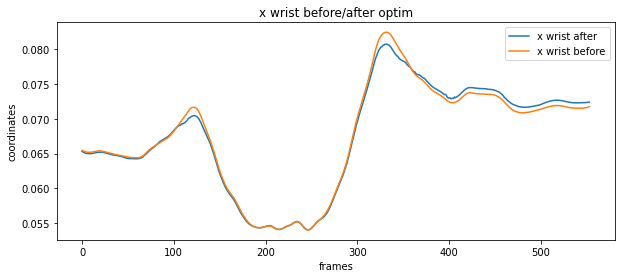

In [35]:
# Low Pass Filter coordinates X coordinates - Optimisation coordinates X coordinates
orig_wrist['frame'] = orig_wrist.index
orig_thumb['frame'] = orig_thumb.index

plt.figure(figsize=(10, 4))
plt.plot(wrist_coord['frame'], wrist_coord['x'], label="x wrist after")
plt.plot(orig_wrist['frame'], orig_wrist['x'], label="x wrist before")
plt.legend()
plt.xlabel("frames")
plt.ylabel("coordinates")
plt.title("x wrist before/after optim")

In [16]:
# Euclidean distance between wrist and thumb after optimisation
eucl_optim=[]

for frame in range (0, len(wrist_coord)):
    data1 = np.vstack(wrist_coord.iloc[frame])
    data2 = np.vstack(thumb1_coord.iloc[frame])
    if ~np.isnan(data1).any() and ~np.isnan(data2).any():
        eucl_optim.append(distance.euclidean(data1, data2))
    else:
        eucl_optim.append(np.float64('nan'))

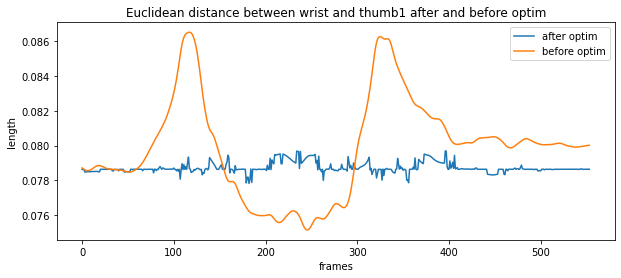

In [32]:
# Euclidean distance difference
frames = [i for i in range(0, len(eucl_optim))]

plt.figure(figsize=(10, 4))
plt.plot(frames, eucl_optim, label="after optim")
plt.plot(frames, length_joints_lpf[1], label='before optim')
plt.xlabel("frames")
plt.ylabel("length")
plt.title("Euclidean distance between wrist and thumb1 after and before optim")
plt.legend()
plt.show()